# Lookiero Take Home Test

## Contenido

### Preprocessing pipeline 1 

    1. Valores núlos
    2. Análisis Univariante y bivariante

### Preprocessing pipeline 2

    1. Estandarización de los datos
    2. Selección de atributos
    3. Reducción de atributos

### Comparación y selección de modelos. 
    
    1. Nested Cross Validation
    2. Hyperparameter tuning con Gridserach

### Diagnostico de desempeño

    1. Gráficos de aprendizaje y validación para mejorar el overfitting
    2. Implemetación de estrategias para mejorar overfitting en el modelo ganador

### Conclusiones
    1. Observaciones

### Propuestas de mejora
    1. Observaciones

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 100000000)
import warnings

In [2]:
# Read Data 
df = pd.read_csv('prueba.csv')

In [3]:
# Initial Preprocessing pipeline

# Dealing with missing values
df.isna().sum().sum()

0

### Preprocessing pipeline 1

#### Bivariate and Univariate Analysis

<Figure size 360x360 with 0 Axes>

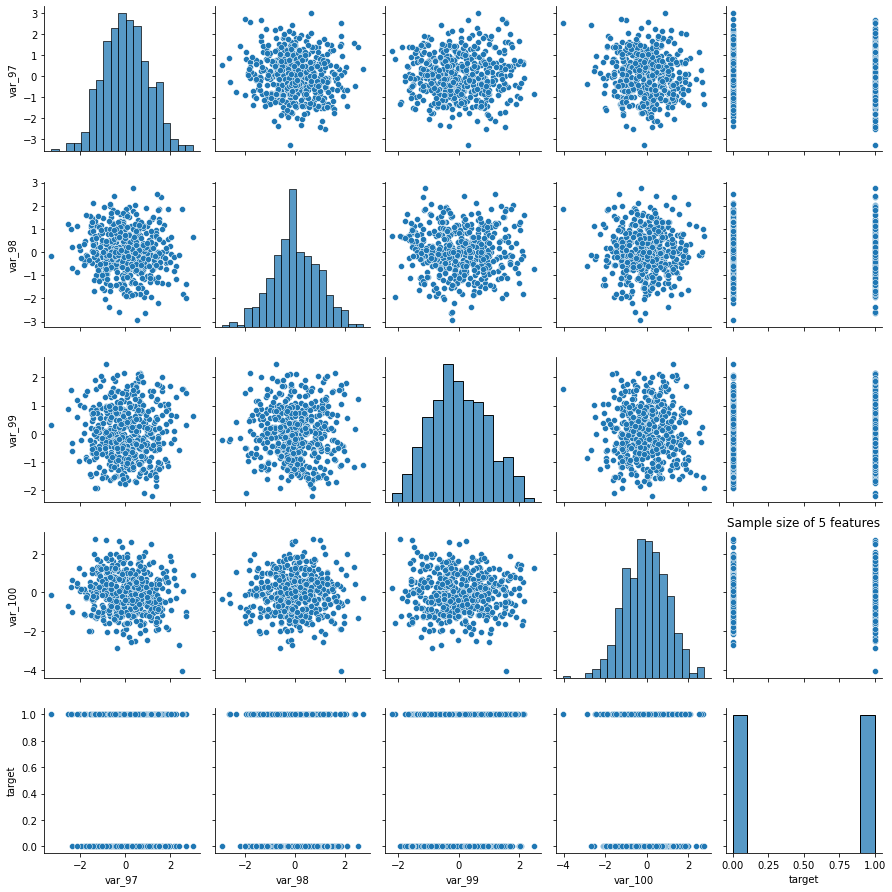

In [4]:

plt.figure(figsize=(5,5))
sns.pairplot(df.iloc[:,96:])
plt.title('Sample size of 5 features')
plt.tight_layout()
plt.show()


`Observaciones`: 

- En el pairplot observamos la correlación entre variables para una muestra de 5 con la variable target. 
- Observamos que son variables con correlación nula lo cual indica que el dataset ha sido generado de manera aleatoria y con distribución normal
- Se ha analizaron las variables restantes y se llego a la misma conclusión


In [5]:
# Feature Selection via VarianceTreshold

from sklearn.feature_selection import VarianceThreshold
def drop_low_variance_predictors(dataframe, thresh):
    '''Removing predictors with variance below threshold.

    Function calculates variance for each column in provided dataframe using
    scikit VarianceThreshold method. Then variables with variance below provided
    threshold are separated from inital dataframe.

    Args:
        dataframe: pandas dataframe
        threshold: float indicating selected level of variance threshold

    Returns:
        dframe: pandas dataframe with predictors having variance greater or equal
            to threshold.
    '''

    all_columns = dataframe.columns

    # instantiate VarianceThreshold object
    v_t = VarianceThreshold(threshold=thresh)

    # fit vt to data
    v_t.fit(dataframe)
    feature_indices = v_t.get_support(indices=True)
    feature_names = all_columns[feature_indices]

    # get the columns to be removed
    removed_features = list(np.setdiff1d(all_columns, feature_names))
    print("Found {0} low-variance columns.".format(len(removed_features)))

    print("Removing low-variance features.")
    # remove the low-variance columns
    x_removed = v_t.transform(dataframe)
    dframe = pd.DataFrame(data=x_removed, columns=feature_names)
    print("Succesfully removed low-variance columns.")

    return dframe

In [6]:
df_vt = df.iloc[:, :-1]
df_vt = drop_low_variance_predictors(df_vt ,0.40)

Found 0 low-variance columns.
Removing low-variance features.
Succesfully removed low-variance columns.


`Observaciones`: 

- Para este análisis univariante, observamos que no hay ninguna variable que tenga varianza por debajo del umbral de 0.40
- Concluimos que utilizando métodos que solo tienen en cuenta las propiedades intrinsecas de los atributos no podemos reducir el dataset
- Continuamos con métodos má sofisticados que tienen en cuenta el desempeño de un modelo (accuracy)
- Método selecionado: **Sequential Feature Selection**

### Preprocessing Pipeline 2

- Feature Scaling 
- Baseline
- Dimensionality Reduction with Wrapper method

In [7]:
# Feature Selection with Wrapper method 

from sklearn.preprocessing import StandardScaler

# Initialize  Standarization 
sc = StandardScaler()

#  Train / Test Split
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=1, 
                     stratify=y)

In [8]:
# Standarize Training  and Test data
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [9]:
# Set up baseline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Initialize baseline with fixed random_state
baseline = DecisionTreeClassifier(random_state=1)

# Fit Baseline with original training data
baseline.fit(X_train_sc, y_train)

print(f'Baseline Training Accuracy: {np.mean(baseline.predict(X_train_sc) == y_train)*100:.2f}% ')
print(f'Baseline Test Accuracy: {np.mean(baseline.predict(X_test_sc) == y_test)*100:.2f}% ')


Baseline Training Accuracy: 100.00% 
Baseline Test Accuracy: 56.00% 


`Observaciones`: 

- Para el baseline sin ningún tipo de estrategía de hiperparametros o selección de variables tenemos un umbral de accuracy por el cual partir: 52%
- Hay una clara señal de overfitting.

In [10]:

#Initial Feature selection with wrapper method
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs1 = SFS(baseline, 
           k_features=30, # In previous iterations with SFS we saw that 30 features were optimal to be a starting point
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=5)


sfs1 = sfs1.fit(X_train_sc, y_train)

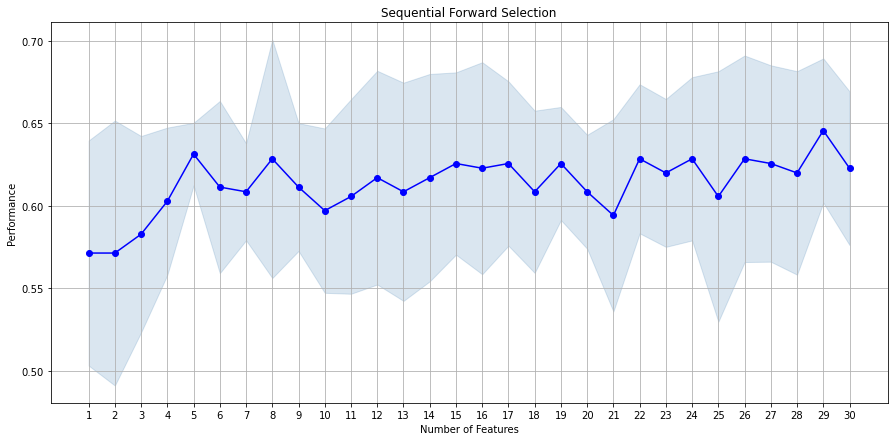

In [11]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs 
metric_dict = sfs1.get_metric_dict(confidence_interval=0.95) 
fig1 = plot_sfs(metric_dict, kind='std_dev',figsize=(15,7))
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

`Observaciones`: 

- Este método wrapper nos ayuda a ver cuantos y cuales atributos podemos seleccionar del dataset basados en el desempeño de predicción de un algoritmo, en este caso del baseline. 
- La sombra azul claro nos enseña la desviación estandar por cada deempeño de predicción segun el número de atributos. En este caso observamos que hay mucha variabilidad. Lo cual no es buena señal ya que la prediccón tiene más apertura a cambiar. 
- Tenemos mucha variabilidad si usamos mas de 10 atributos para un desempeño mayor de 65%


In [12]:
# Reducing Dataset with 30 selected features based on SFS

X_train_select = sfs1.transform(X_train_sc)
X_test_select = sfs1.transform(X_test_sc)

In [13]:
# Fit baseline with new selected dataset 

baseline.fit(X_train_select, y_train)

print(f'Baseline on SFS Training Accuracy: {np.mean(baseline.predict(X_train_select) == y_train)*100:.2f}% ')
print(f'Baseline on SFS Test Accuracy: {np.mean(baseline.predict(X_test_select) == y_test)*100:.2f}% ')

Baseline on SFS Training Accuracy: 100.00% 
Baseline on SFS Test Accuracy: 44.67% 


`Observaciones`: 

- Logramos incrementar el accuracy en el test con el nuevo dataset, pero sigue habiendo una señal fuerte de overfitting 

#### Feature Reduction with PCA


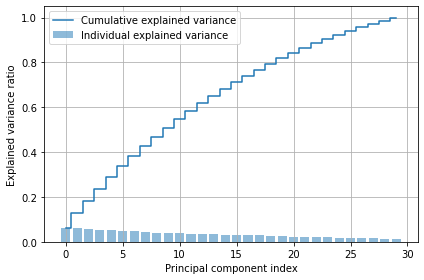

In [14]:
# Plot a PCA 

from sklearn.decomposition import PCA

# Initialize PCA without a fixed number of components in order to see how many do we need 
pca = PCA()

# Fit PCA on previous selected dataframe with SFS
X_train_pca = pca.fit_transform(X_train_select)
X_test_pca = pca.fit_transform(X_test_select)

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.show()

`Observaciones`: 

- En el gráfico se observa que a nivel individual ningun componente explica la varianza del dataset
- A nivel acomulativo, se observa que podemos explicar el 80% de la varianza con al menos 17 componentes

In [15]:
# Iteration with PCA

# According to PCA we can explain 80% of the variance with 17 principal components
pca_17 = PCA(n_components=17)

# Fit PCA to dataset 
X_train_pca_17 = pca_17.fit_transform(X_train_select)
X_test_pca_17 = pca_17.fit_transform(X_test_select)

# Fit baseline with 17 principal component dataset
baseline.fit(X_train_pca_17, y_train)


print(f'Baseline on SFS + reduced PCA Training Accuracy: {np.mean(baseline.predict(X_train_pca_17) == y_train)*100:.2f}% ')
print(f'Baseline on SFS + reduced PCA Test Accuracy: {np.mean(baseline.predict(X_test_pca_17) == y_test)*100:.2f}% ')

Baseline on SFS + reduced PCA Training Accuracy: 100.00% 
Baseline on SFS + reduced PCA Test Accuracy: 47.33% 


`Observaciones`: 
- Seguimos teniendo el mismo patron de caida en las predicciones. 
- Para efectos de las siguientes iteraciones no vamos a utilzar PCA ya que no nos dio buenos resultados

### Algorithm Selection and Hyperparameter Tuning via Nested Cross Validation 

Breve descripción: El método de Nested CV consiste en anidar dos bucles de validación cruzada: el búcle interior es responsable de la selección del modelo y el bucle exterior es responsable de estimar el desempeño del modelo.

Búcle exterior: Entrena con los parámetros óptimos del Búcle interior y hace un promedio de la generalización

Búcle interior: Ajusta los parametros

Seleccionamos una batería diversa de algoritmos para ver cual obtiene el mejor desempeño:

1. LogisticRegression: Modelo regularizado .

2. KNeighborsClassifier: Modelo basado en distancias.

3. LightGradientBoosting: Modelo de arbol con técnica boosting.

4. SVC: Segundo modelo regularizado.

5. RandomForestClassifier: Segundo modelo de arbol.



In [17]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgbm


# Initializing Classifiers
clf1 = LogisticRegression(random_state=1,)
clf2 = KNeighborsClassifier()
clf3 = lgbm.LGBMClassifier(random_state=1) 
clf4 = SVC(random_state=1)
clf5 = RandomForestClassifier(random_state=1)

# Initialize parameters grid to perform Hiperparameter Optimization via GridSearchCV
parameter_grid1 = [{'penalty': ['l2'],
                'C': np.power(10., np.arange(-4, 4))}]

parameter_grid2 = [{'n_neighbors': list(range(1, 10)),
                'p': [1, 2]}]

parameter_grid3 = [ { 
                'learning_rate': [0.05],
                'n_estimators': [400,500,600,700,800,900,1000],
                'reg_alpha' : (1,1.2),
                'reg_lambda' : (1,1.2,1.4)
                }]

parameter_grid4 = [{'kernel': ['rbf'],
                'C': np.power(10., np.arange(-4, 4)),
                'gamma': np.power(10., np.arange(-5, 0))},
               {'kernel': ['linear'],
                'C': np.power(10., np.arange(-4, 4))}]

parameter_grid5 = [{'n_estimators': [10, 100, 500, 1000, 10000]}]

In [18]:
# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip((parameter_grid1,
                             parameter_grid2, 
                             parameter_grid3,
                            parameter_grid4, 
                             parameter_grid5),
                             
                            (clf1, clf2, clf3, clf4, clf5),
                            ('Logistic Regression', 'KNeighborsClassifier', 'LGBM', 'SCV', 'RandomForest')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring='accuracy',
                       n_jobs=1, 
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
    gridcvs[name] = gcv

In [27]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


for name, gs_est in sorted(gridcvs.items()):
    nested_score = cross_val_score(gs_est, 
                                   X=X_train_select, 
                                   y=y_train, 
                                   cv=outer_cv,
                                   n_jobs=1) 
    print(f'{name:<7} | outer ACC {100*nested_score.mean():.2f}% +/- {100*nested_score.std():.2f}')

KNeighborsClassifier | outer ACC 51.14% +/- 4.46
LGBM    | outer ACC 46.00% +/- 1.40
Logistic Regression | outer ACC 44.86% +/- 3.90
RandomForest | outer ACC 49.71% +/- 7.08
SCV     | outer ACC 50.00% +/- 1.56


In [20]:
# Based on Nested  nested cross validation we see that LGB performs the best
# Now we select the best hp on the whole traininng set

gcv_model_select = GridSearchCV(estimator=clf3,
                                param_grid=parameter_grid3,
                                scoring='accuracy',
                                n_jobs=1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train_select, y_train)
print('Best CV accuracy: %.2f%%' % (gcv_model_select.best_score_*100))
print('Best parameters:', gcv_model_select.best_params_)

Fitting 2 folds for each of 42 candidates, totalling 84 fits
Best CV accuracy: 46.86%
Best parameters: {'learning_rate': 0.05, 'n_estimators': 400, 'reg_alpha': 1, 'reg_lambda': 1}


In [21]:
from sklearn.metrics import accuracy_score
best_model = gcv_model_select.best_estimator_

train_acc = accuracy_score(y_true=y_train, y_pred=best_model.predict(X_train_select))
test_acc = accuracy_score(y_true=y_test, y_pred=best_model.predict(X_test_select))

print(f'Nested CV Accuracy {100 * gcv_model_select.best_score_:.2f}% (average over k-fold CV test folds)')
print(f'Best Parameters: {gcv_model_select.best_params_}')

print(f'Training Accuracy {100 * train_acc:.2f}%')
print(f'Test Accuracy {100 * test_acc:.2f}%')

Nested CV Accuracy 46.86% (average over k-fold CV test folds)
Best Parameters: {'learning_rate': 0.05, 'n_estimators': 400, 'reg_alpha': 1, 'reg_lambda': 1}
Training Accuracy 100.00%
Test Accuracy 52.00%


`Observaciones`: 
- Seguimos teniendo un problema de overfitting. 
- Para los modelos de arbol, un buen punto de partida es reducir el número de particiones o n_estimators. Vemos que el modelo ganador tiene 400. Vamos a intentar reducir el grid 

### Model diagnostics

In [22]:
from sklearn.model_selection import validation_curve


num_estimators_lgbm = [10,20,30,50,100,200,300,400]
train_scores, test_scores = validation_curve(
                estimator=best_model, 
                X=X_train_select, 
                y=y_train, 
                param_name='n_estimators', 
                param_range = num_estimators_lgbm,
                cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

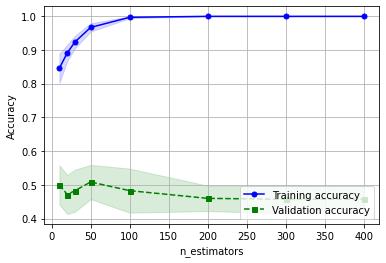

In [23]:
plt.plot(num_estimators_lgbm, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(num_estimators_lgbm, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(num_estimators_lgbm, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(num_estimators_lgbm, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

`Observaciones`: 
- En este gráfico podemos ver que reduciendo el número de estimadores pordemos mejorar ligeramente el problema de overfitting


In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=best_model,
                               X=X_train_select,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


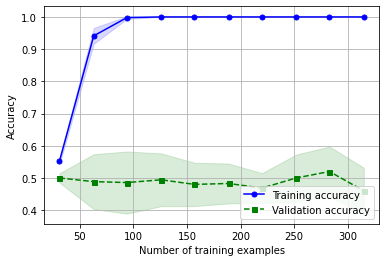

In [25]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

`Observaciones`: 
- En este gráfico también podemos ver que si reducimos la complejidad del dataset también podemos mejorar el problema de overfitting

### Final Model

In [ ]:
sfs2 = SFS(lgbm.LGBMClassifier(random_state=1), # Instanciate winning model
           k_features=5, # Reduce data complexity to 5 features
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='accuracy',
           cv=5)


sfs2 = sfs2.fit(X_train_sc, y_train)

In [26]:
# Reducing Dataset based on SFS
X_train_select_final = sfs2.transform(X_train_sc)
X_test_select_final = sfs2.transform(X_test_sc)

NameError: name 'sfs2' is not defined

In [ ]:
best_model

In [ ]:
# We  use the best hiperparameters found in GridSearch but only decerease de number of n_estimators to improve overfitting
final_model = lgbm.LGBMClassifier(random_state=1, learning_rate= 0.05,
n_estimators=100, reg_alpha=1, reg_lambda=1.4
)  

final_model.fit(X_train_select_final, y_train)
train_acc_2it = accuracy_score(y_true=y_train, y_pred=final_model.predict(X_train_select_final))
test_acc_2it = accuracy_score(y_true=y_test, y_pred=final_model.predict(X_test_select_final))


print(f'Training Accuracy {100 * train_acc_2it:.2f}%')
print(f'Test Accuracy {100 * test_acc_2it:.2f}%')

In [ ]:
# learning curve
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=final_model,
                               X=X_train_select_final,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 5),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [ ]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

`Conclusiones`: 
- Se hizo un pipeline completo de modelado. 
- En la inspección del dataset se observo que las variables tenían correlación nula entre ellas y con el target. Tenía toda la pinta de ser un random generated con distribución normal
- No se pudo reducir el dataset con técnicas univariantes como el umbral de varianza ya que la naturaleza intrinseca del dataset era débil 
- Se opto por metodos wrapper para reducir la compljidad del dataset
- Para la selección de modelos se utilizo la técinca de Nested Cross Validation la cual es una validación cruzada que utiliza 2 loops para reducir el sesgo
- Se utilizaron técnicas de diagnóstico de overfitting como las learning curves y las validation curves. 
- Basado en técnicas sencillas como la reducción de complejidad del dataset y la profundiad del arbol se intento mejorar el problema de overfitting. 

`Propuestas de mejora`
- Como se vio que el dataset no contribuia ampliamente al overfitting, se propone ampliar otras técinca como la ingieneria de atributos. Importante mencionar que la ingienería de atributos es eficiente si el dataset tiene un naturaleza númerica, dado que este dataset es random se podría intentar ampliar con transformaciones númericas aritmeticas o polinomiales. 
- Proponer un ensamblado de modelos


## ¡Eskerrik asko!